In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import json
import time

import matplotlib.pyplot as plt
import umap.umap_ as umap
import torch
from torch.utils.data import DataLoader
from transformers import get_scheduler
from sklearn.model_selection import train_test_split

from utils import get_digit_and_unit
from model import NumericOperationDataset, NumericalNet

2024-04-03 13:03:29.099635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 13:03:29.823452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_path = "/workspace/Data/NumericalNet/20240401_numericalnet_data_small.xlsx"

with pd.ExcelFile(data_path) as xls:
    df_equal = pd.read_excel(xls, 'equal')
    df_greater = pd.read_excel(xls, 'greater')
    df_less = pd.read_excel(xls, 'less')

data = pd.concat([df_equal, df_greater, df_less], ignore_index=True)
data

,value1,operation,value2,type
0,678.8mm,=,67.88cm,length
1,302.78cm,=,3027.8mm,length
2,109.19mm,=,10.919cm,length
3,479.32cm,=,4793.2mm,length
4,83.32mm,=,8.332cm,length
...,...,...,...,...
18160,1559.5ml,<,1.58544l,NaN
18161,9733.4ml,<,12.37443l,NaN
18162,4343.3ml,<,6.07581l,NaN
18163,9.21l,<,13396.19ml,NaN


In [3]:
# Test: get_digit_and_unit
test_data = ["2km", "2000cm", "22mm", "1kg", "8.9ml", "0.28l", "11.1g", "0.5mg", "0.56m"]

for td in test_data:
    print(f"{td}: {get_digit_and_unit(td)}")

2km: (2.0, 'km')
2000cm: (2000.0, 'cm')
22mm: (22.0, 'mm')
1kg: (1.0, 'kg')
8.9ml: (8.9, 'ml')
0.28l: (0.28, 'l')
11.1g: (11.1, 'g')
0.5mg: (0.5, 'mg')
0.56m: (0.56, 'm')


In [4]:
# Preprocess dataset

dataset = []
target_units = set()

for _, row in data.iterrows():
    value1, unit1 = get_digit_and_unit(row['value1'])
    value2, unit2 = get_digit_and_unit(row['value2'])
    operation = row['operation']
    dataset.append((value1, unit1, value2, unit2, operation))
    target_units = target_units.union({unit1, unit2})
    
target_units = list(target_units)
target_units = sorted(target_units, key=lambda x: x[-1]) # sort target units by the last character
unit_to_idx = {unit: idx for idx, unit in enumerate(target_units)}

target_operations = ["=", ">", "<"]
operation_to_idx = {op: idx for idx, op in enumerate(target_operations)}

print(f"Number of train data: {len(dataset)}")
print(f"Number of target units: {len(target_units)}")
print(f"Target units: {target_units}")
print(f"Temp Train Data:\n")
dataset[:5]

Number of train data: 18165
Number of target units: 9
Target units: ['kg', 'mg', 'g', 'ml', 'l', 'km', 'm', 'cm', 'mm']
Temp Train Data:



[(678.8, 'mm', 67.88, 'cm', '='),
 (302.78, 'cm', 3027.8, 'mm', '='),
 (109.19, 'mm', 10.919, 'cm', '='),
 (479.32, 'cm', 4793.2, 'mm', '='),
 (83.32, 'mm', 8.332, 'cm', '=')]

In [5]:
# Hyperparameters
train_batch_size = 1024
test_batch_size = 256
num_epochs = 100
num_warmup_steps = 500
early_stopping_patience = 200
test_ratio = 0.1
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.0004
weight_decay=2e-6
lr_scheduler = "cosine"

# Split the data into train and validation
train_dataset, valid_dataset = train_test_split(dataset, test_size=test_ratio, random_state=seed)
tr_ds = NumericOperationDataset(train_dataset, unit_to_idx, operation_to_idx)
val_ds = NumericOperationDataset(valid_dataset, unit_to_idx, operation_to_idx)
tr_dl = DataLoader(tr_ds, batch_size=train_batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=test_batch_size, shuffle=False)

# Model, Optimizer, Scheduler
model = NumericalNet(unit_to_idx, operation_to_idx, device).to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate,
    weight_decay=weight_decay
)
num_training_steps = len(tr_dl) * num_epochs
scheduler = get_scheduler(
    name=lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [6]:
# Training
cnt, best_loss = 0, float('inf')
train_losses, valid_losses = [], []
for idx, epoch in enumerate(range(num_epochs)):
    model.train()
    train_loss = 0.0
    start = time.time()
    for batch in tr_dl:
        batch = [tensor.to(device) for tensor in batch]
        value1, unit1, value2, unit2, operation = batch
        value1_embeddings, value2_embeddings = model(value1), model(value2)

        loss = model.loss_fn(value1_embeddings, value2_embeddings, unit1, unit2, operation)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    train_loss /= len(tr_dl)
    train_losses.append(train_loss)
    
    # Validation    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dl:
            batch = [tensor.to(device) for tensor in batch]
            value1, unit1, value2, unit2, operation = batch
            value1_embeddings, value2_embeddings = model(value1), model(value2)

            loss = model.loss_fn(value1_embeddings, value2_embeddings, unit1, unit2, operation)
            val_loss += loss.item()
            
        val_loss /= len(val_dl)
        valid_losses.append(val_loss)
    elapsed = (time.time() - start)*1000
    if (epoch+1) % 1 == 0:
        print(f"Epoch[{epoch+1}/{num_epochs}]|LR: {optimizer.param_groups[0]['lr']:.6f}|Train Loss: {train_loss:.6f}|Val Loss: {val_loss:.6f}|Elapsed time: {elapsed:.2f}ms")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
        best_epoch = epoch
    else:
        counter += 1
        if counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
# load the best model
model.load_state_dict(torch.load('best_model.pth'))
if os.path.exists('best_model.pth'):
    os.remove('best_model.pth')

print(f"\nBest model loaded with validation loss: {best_loss} at epoch {best_epoch+1}")

Epoch[1/100]|LR: 0.000013|Train Loss: 1453498.765625|Val Loss: 1327065.765625|Elapsed time: 1815.46ms
Epoch[2/100]|LR: 0.000026|Train Loss: 936114.527344|Val Loss: 652069.976562|Elapsed time: 532.01ms
Epoch[3/100]|LR: 0.000038|Train Loss: 388198.655273|Val Loss: 215415.976562|Elapsed time: 860.97ms
Epoch[4/100]|LR: 0.000051|Train Loss: 121708.262207|Val Loss: 65526.104492|Elapsed time: 536.87ms
Epoch[5/100]|LR: 0.000064|Train Loss: 36144.445557|Val Loss: 18985.826050|Elapsed time: 549.68ms
Epoch[6/100]|LR: 0.000077|Train Loss: 10956.514465|Val Loss: 6196.455078|Elapsed time: 546.50ms
Epoch[7/100]|LR: 0.000090|Train Loss: 3763.561844|Val Loss: 2355.169510|Elapsed time: 760.78ms
Epoch[8/100]|LR: 0.000102|Train Loss: 1462.033886|Val Loss: 952.168640|Elapsed time: 575.41ms
Epoch[9/100]|LR: 0.000115|Train Loss: 631.327702|Val Loss: 445.344749|Elapsed time: 596.37ms
Epoch[10/100]|LR: 0.000128|Train Loss: 307.720463|Val Loss: 232.551668|Elapsed time: 640.75ms
Epoch[11/100]|LR: 0.000141|Train 

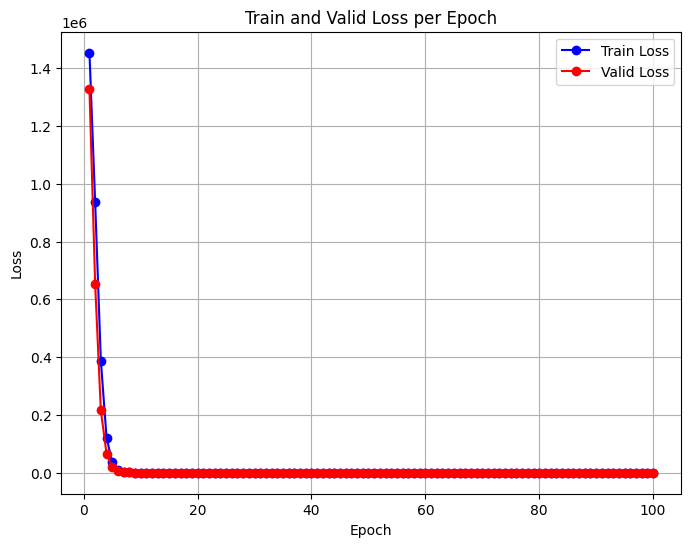

In [7]:
def plot_loss(train_losses, valid_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
    plt.plot(epochs, valid_losses, marker='o', linestyle='-', color='r', label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Valid Loss per Epoch')
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_loss(train_losses, valid_losses)

In [24]:
output_path = "../output/20240403_numericalnet_small_dim200"
os.makedirs(output_path, exist_ok=True)

unit_to_idx_path = os.path.join(output_path, "unit_to_idx.json")
with open(unit_to_idx_path, "w") as f:
    json.dump(unit_to_idx, f, indent=4, ensure_ascii=False)
    
operation_to_idx_path = os.path.join(output_path, "operation_to_idx.json")
with open(operation_to_idx_path, "w") as f:
    json.dump(operation_to_idx, f, indent=4, ensure_ascii=False)

torch.save(model.state_dict(), os.path.join(output_path, "best_model.pth"))
print(f"Compete saving the trained model")

Compete saving the trained model


## Visualization

In [8]:
def get_numeric_range(start, end, step, device=device):
    numeric_range = torch.arange(start, end, step, dtype=torch.float32).view(-1, 1).to(device)
    return numeric_range

def get_numeric_embeddings(model, device, start=0, end=10, step=0.1):
    numeric_range = torch.arange(start, end, step, dtype=torch.float32).view(-1, 1).to(device)
    with torch.no_grad():
        numeric_embeddings = model(numeric_range)

    numeric_embeddings = numeric_embeddings.squeeze(1)
    return numeric_embeddings.cpu().numpy()

def get_unit_embeddings(unit, unit_to_idx, model=model, device=device):
    with torch.no_grad():
        unit_idx = torch.tensor(unit_to_idx[unit]).to(device)
        unit_embedding = model.get_unit_embedding(unit_idx).cpu().numpy()
    return unit_embedding

def get_numeric_unit_embedding(digit, unit, model=model, device=device):
    
    digit_input = torch.tensor([digit], dtype=torch.float32).view(-1,1).to(device)
    unit_input = torch.tensor([unit_to_idx[unit]], dtype=torch.long).to(device)
    
    with torch.no_grad():
        temp_numeric_embedding = model(digit_input)
        temp_unit_embedding = model.get_unit_embedding(unit_input)
        temp_unit_embedding = temp_unit_embedding.unsqueeze(0)
        joint_embedding = model.joint_embedding(temp_numeric_embedding, temp_unit_embedding).cpu().numpy()
    
    return joint_embedding

def apply_umap(embeddings, n_components=2):
    umap_model = umap.UMAP(n_components=n_components)
    reduced = umap_model.fit_transform(embeddings)
    return reduced

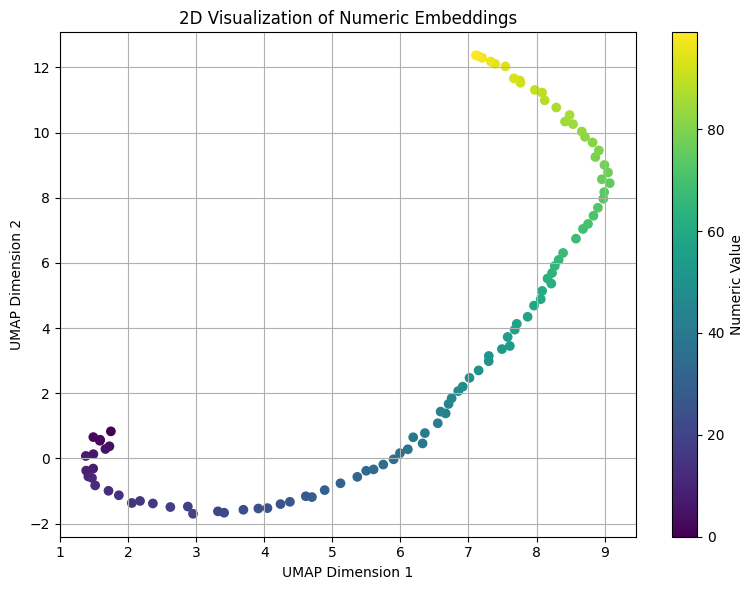

In [9]:
start, end, step = 0, 100, 1
numeric_embeddings_0_to_100 = get_numeric_embeddings(model, device, start, end, step)
numeric_embeddings_2d = apply_umap(numeric_embeddings_0_to_100)

plt.figure(figsize=(8, 6))
plt.scatter(numeric_embeddings_2d[:, 0], numeric_embeddings_2d[:, 1], c=np.arange(start, end, step), cmap='viridis')
plt.colorbar(label='Numeric Value')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Numeric Embeddings')
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


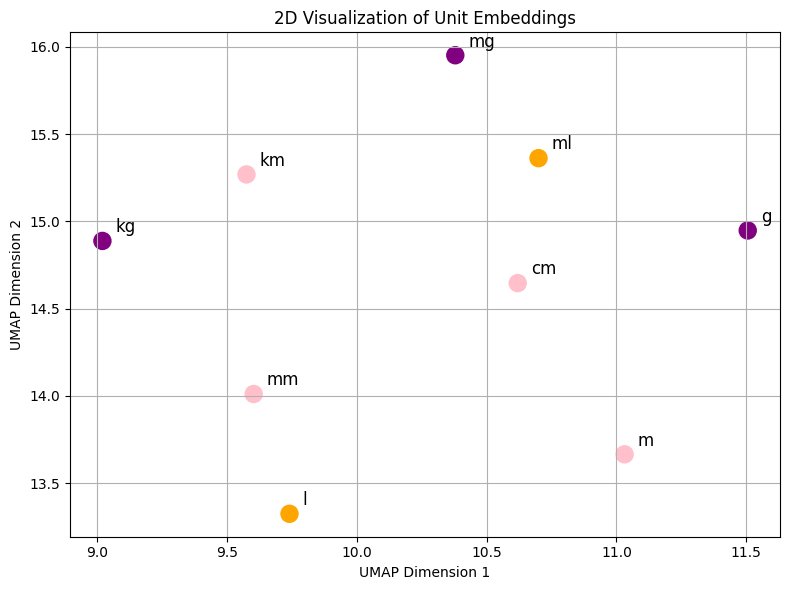

In [10]:
units= ['g', 'mg', 'kg', 'ml', 'l', 'cm', 'km', 'mm', 'm']
colors = ['purple', 'purple', 'purple', 'orange', 'orange', 'pink', 'pink', 'pink', 'pink']

# Get unit_embeddings
unit_embeddings = []
for unit in units:
    unit_embeddings.append(get_unit_embeddings(unit, unit_to_idx, model, device))
unit_embeddings_2d = apply_umap(unit_embeddings)

# Create a scatter plot for unit embeddings with labels
plt.figure(figsize=(8, 6))
plt.scatter(unit_embeddings_2d[:, 0], unit_embeddings_2d[:, 1], c=colors[:len(target_units)], marker='o', s=150)

# Add labels for each unit embedding
for i in range(len(target_units)):
    plt.text(unit_embeddings_2d[i, 0]+0.05, unit_embeddings_2d[i, 1]+0.05, target_units[i], fontsize=12)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Unit Embeddings')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_23049/2756037262.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(digit_unit_ranges))
/tmp/ipykernel_23049/2756037262.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)


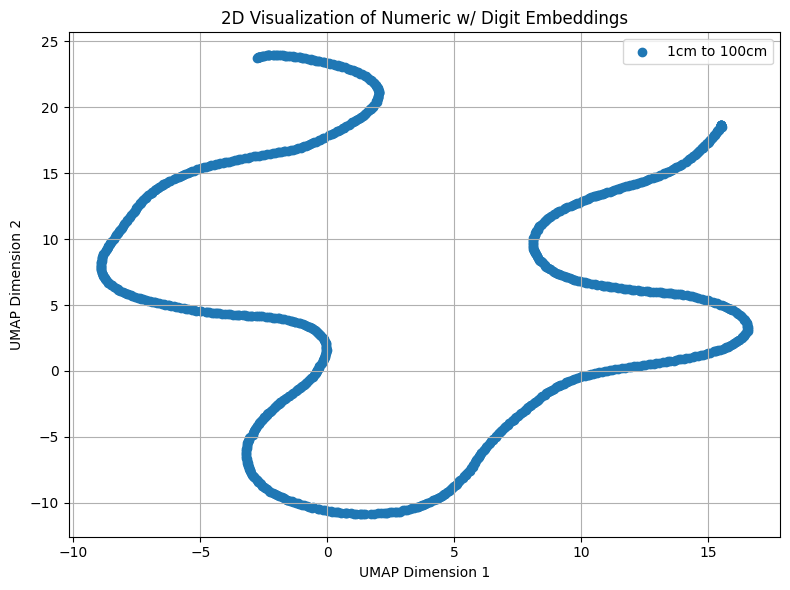

In [11]:
digit_unit_ranges = [
    ("cm", 1, 100, 0.1),
]

numeric_digit_embeddings = []
numeric_digit_labels = []
with torch.no_grad():
    for idx, (unit, start, end, step) in enumerate(digit_unit_ranges):
        temp_digit_unit_range = get_numeric_range(start, end, step)
        for digit in temp_digit_unit_range:
            temp_embedding = model.get_digit_unit_embedding(digit, unit)
            numeric_digit_embeddings.append(temp_embedding.cpu().numpy())
        numeric_digit_labels.append(np.ones(len(temp_digit_unit_range))*idx)

embeddings = np.concatenate(numeric_digit_embeddings)
embeddings_2d = apply_umap(embeddings)
labels = np.concatenate(numeric_digit_labels)
unique_labels = np.unique(labels)
labels_text = [f'{x[1]}{x[0]} to {x[2]}{x[0]}' for x in digit_unit_ranges]

# Generate colors for each range
cmap = plt.cm.get_cmap('tab20', len(digit_unit_ranges))
colors = [cmap(i) for i in range(len(digit_unit_ranges))] 

# Draw Plots
plt.figure(figsize=(8, 6))
for label, color, text in zip(unique_labels, colors, labels_text):
    mask = labels == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Numeric w/ Digit Embeddings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Advanced Visualization

/tmp/ipykernel_23049/1403385091.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(ranges))
/tmp/ipykernel_23049/1403385091.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)


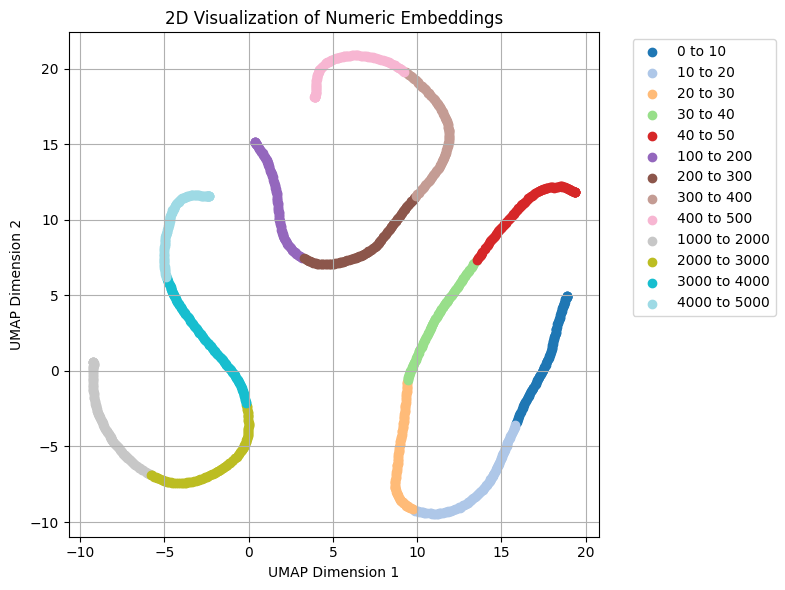

In [12]:
ranges = [
    (0, 10, 0.1),
    (10, 20, 0.1),
    (20, 30, 0.1),
    (30, 40, 0.1),
    (40, 50, 0.1),
    (100, 200, 1),
    (200, 300, 1),
    (300, 400, 1),
    (400, 500, 1),
    (1000, 2000, 10),
    (2000, 3000, 10),
    (3000, 4000, 10),
    (4000, 5000, 10)
]

# Generate embeddings for each range
numeric_embeddings = [get_numeric_embeddings(model, device, start, end, step) for start, end, step in ranges]
embeddings = np.concatenate(numeric_embeddings)
embeddings_2d = apply_umap(embeddings)

# Generate labels for each range
labels_list = []
for i, embeddings in enumerate(numeric_embeddings):
    labels_list.append(np.ones(embeddings.shape[0]) * i)
labels = np.concatenate(labels_list)
unique_labels = np.unique(labels)
labels_text = [f'{x[0]} to {x[1]}' for x in ranges]

# Generate colors for each range
cmap = plt.cm.get_cmap('tab20', len(ranges))
colors = [cmap(i) for i in range(len(ranges))] 

# Draw Plots
plt.figure(figsize=(8, 6))
for label, color, text in zip(unique_labels, colors, labels_text):
    mask = labels == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Numeric Embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_23049/490423761.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(ranges))
/tmp/ipykernel_23049/490423761.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)


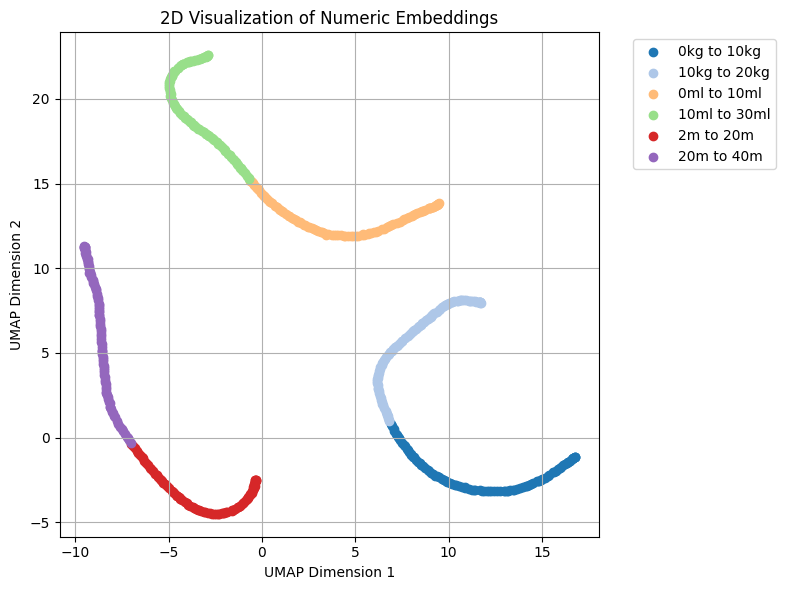

In [14]:
digit_unit_ranges = [
    ("kg", 0, 10, 0.1),
    ("kg", 10, 20, 0.1),
    ("ml", 0, 10, 0.1),
    ("ml", 10, 30, 0.2),
    ("m", 2, 20, 0.2),
    ("m", 20, 40, 0.2),
]

numeric_digit_embeddings = []
numeric_digit_labels = []
with torch.no_grad():
    for idx, (unit, start, end, step) in enumerate(digit_unit_ranges):
        temp_digit_unit_range = get_numeric_range(start, end, step)
        for digit in temp_digit_unit_range:
            temp_embedding = model.get_digit_unit_embedding(digit, unit)
            numeric_digit_embeddings.append(temp_embedding.cpu().numpy())
        numeric_digit_labels.append(np.ones(len(temp_digit_unit_range))*idx)

embeddings = np.concatenate(numeric_digit_embeddings)
embeddings_2d = apply_umap(embeddings)
labels = np.concatenate(numeric_digit_labels)
unique_labels = np.unique(labels)
labels_text = [f'{x[1]}{x[0]} to {x[2]}{x[0]}' for x in digit_unit_ranges]

# Generate colors for each range
cmap = plt.cm.get_cmap('tab20', len(ranges))
colors = [cmap(i) for i in range(len(ranges))] 

# Draw Plots
plt.figure(figsize=(8, 6))
for label, color, text in zip(unique_labels, colors, labels_text):
    mask = labels == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Numeric Embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_23049/739907037.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(ranges))
/tmp/ipykernel_23049/739907037.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)


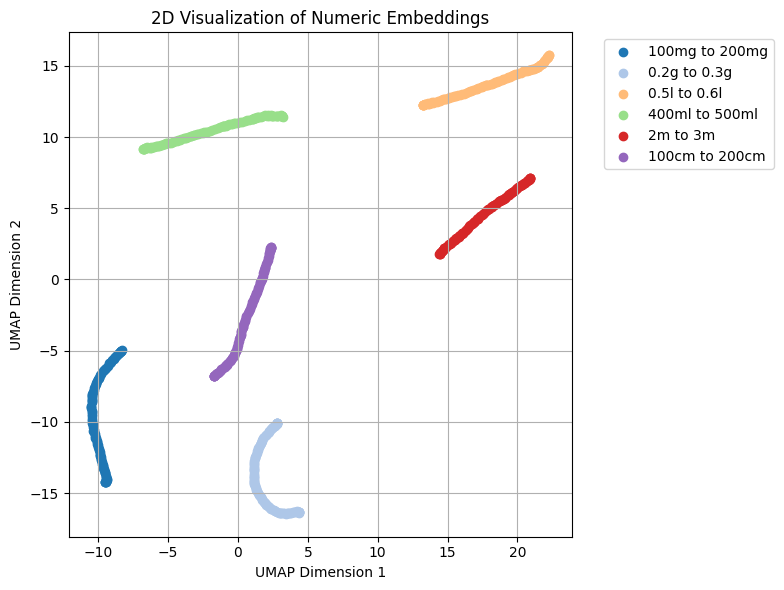

In [15]:
digit_unit_ranges = [
    ("mg", 100, 200, 1),
    ("g", 0.2, 0.3, 0.001),
    ("l", 0.5, 0.6, 0.001),
    ("ml", 400, 500, 1),
    ("m", 2, 3, 0.01),
    ("cm", 100, 200, 1),
]

numeric_digit_embeddings = []
numeric_digit_labels = []
with torch.no_grad():
    for idx, (unit, start, end, step) in enumerate(digit_unit_ranges):
        temp_digit_unit_range = get_numeric_range(start, end, step)
        for digit in temp_digit_unit_range:
            temp_embedding = model.get_digit_unit_embedding(digit, unit)
            numeric_digit_embeddings.append(temp_embedding.cpu().numpy())
        numeric_digit_labels.append(np.ones(len(temp_digit_unit_range))*idx)

embeddings = np.concatenate(numeric_digit_embeddings)
embeddings_2d = apply_umap(embeddings)
labels = np.concatenate(numeric_digit_labels)
unique_labels = np.unique(labels)
labels_text = [f'{x[1]}{x[0]} to {x[2]}{x[0]}' for x in digit_unit_ranges]

# Generate colors for each range
cmap = plt.cm.get_cmap('tab20', len(ranges))
colors = [cmap(i) for i in range(len(ranges))] 

# Draw Plots
plt.figure(figsize=(8, 6))
for label, color, text in zip(unique_labels, colors, labels_text):
    mask = labels == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=text)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Numeric Embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Distance Check

In [16]:
# 2m, 200cm, 1.9m, 190cm, 1.8m, 1.95m

with torch.no_grad():
    digit, unit = 2, "m"
    embedding_2m = model.get_digit_unit_embedding(digit, unit).cpu().numpy()
    
    digit, unit = 1.9, "m"
    embedding_1_9m = model.get_digit_unit_embedding(digit, unit).cpu().numpy()
    
    digit, unit = 1.8, "m"
    embedding_1_8m = model.get_digit_unit_embedding(digit, unit).cpu().numpy()
    
    digit, unit = 200, "cm"
    embedding_200cm = model.get_digit_unit_embedding(digit, unit).cpu().numpy()
    
    digit, unit = 190, "cm"
    embedding_190cm = model.get_digit_unit_embedding(digit, unit).cpu().numpy()
    
    digit, unit = 1.95, "m"
    embedding_1_95m = model.get_digit_unit_embedding(digit, unit).cpu().numpy()
    
    digit, unit = 42, 'ml'
    embedding_42ml = model.get_digit_unit_embedding(digit, unit).cpu().numpy()

In [17]:
# 2m vs 1.95m, 2m vs 1.9m, 2m vs 1.8m

diff_2m_1_95m = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_1_95m)
diff_2m_1_9m = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_1_9m)
diff_2m_1_8m = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_1_8m)

print(f"Difference between 2m and 1.95m: {diff_2m_1_95m}")
print(f"Difference between 2m and 1.9m: {diff_2m_1_9m}")
print(f"Difference between 2m and 1.8m: {diff_2m_1_8m}")

Difference between 2m and 1.95m: -0.004074692726135254
Difference between 2m and 1.9m: -0.008282065391540527
Difference between 2m and 1.8m: -0.016942143440246582


In [18]:
# 2m vs 200cm, 1.9m vs 190cm

diff_2m_200cm = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_200cm)
diff_1_9m_190cm = np.linalg.norm(embedding_1_9m) - np.linalg.norm(embedding_190cm)

print(f"Difference between 2m and 200cm: {diff_2m_200cm}")
print(f'Difference between 1.9m and 190cm: {diff_1_9m_190cm}')

Difference between 2m and 200cm: 0.1338406801223755
Difference between 1.9m and 190cm: 0.1415635347366333


In [19]:
# 2m vs 190cm, 200cm vs 1.9m

diff_2m_190cm = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_190cm)
diff_200cm_1_9m = np.linalg.norm(embedding_200cm) - np.linalg.norm(embedding_1_9m)

print(f"Difference between 2m and 190cm: {diff_2m_190cm}")
print(f'Difference between 200cm and 1.9m: {diff_200cm_1_9m}')

Difference between 2m and 190cm: 0.13328146934509277
Difference between 200cm and 1.9m: -0.14212274551391602


In [20]:
# 2m vs 200cm, 2m vs 1.9m, 2m vs 1.8m, 2m vs 42ml

diff_2m_200cm = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_200cm)
diff_2m_1_9m = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_1_9m)
diff_2m_1_8m = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_1_8m)
diff_2m_42ml = np.linalg.norm(embedding_2m) - np.linalg.norm(embedding_42ml)

print(f"Difference between 2m and 200cm: {diff_2m_200cm}")
print(f"Difference between 2m and 1.9m: {diff_2m_1_9m}")
print(f"Difference between 2m and 1.8m: {diff_2m_1_8m}")
print(f"Difference between 2m and 42ml: {diff_2m_42ml}")

Difference between 2m and 200cm: 0.1338406801223755
Difference between 2m and 1.9m: -0.008282065391540527
Difference between 2m and 1.8m: -0.016942143440246582
Difference between 2m and 42ml: 0.6511375904083252


    동일 단위에서는 잘 동작하지만, 단위가 달라질 경우 값이 크게 증가.
    0 value 에 대한 설명력 부족
    마이너스에 대한 개념 X

In [20]:
# 0cm, 0ml, 0km, 0cm

with torch.no_grad():
    digit, unit = 0.0, "m"
    embedding_0m = model.get_digit_unit_embedding(digit, unit).cpu().numpy()
    embedding_0ml = model.get_digit_unit_embedding(digit, "ml").cpu().numpy()
    embedding_0km = model.get_digit_unit_embedding(digit, "km").cpu().numpy()
    embedding_0cm = model.get_digit_unit_embedding(digit, "cm").cpu().numpy()
    embedding_0 = model.get_digit_embedding(0).cpu().numpy()
    
print(f"Embedding for 0m: {embedding_0m[0][:5]}")
print(f"Embedding for 0ml: {embedding_0ml[0][:5]}")
print(f"Embedding for 0km: {embedding_0km[0][:5]}")
print(f"Embedding for 0cm: {embedding_0cm[0][:5]}")
print(f"Embedding for 0: {embedding_0[:5]}")

Embedding for 0m: [ 0.00012482  0.0006551  -0.0004143   0.00053823  0.00089099]
Embedding for 0ml: [ 0.02658336  0.00211163 -0.0134074  -0.00590824 -0.01299111]
Embedding for 0km: [-0.00016385  0.00019265  0.00035314  0.00030355  0.00061174]
Embedding for 0cm: [-1.07841275e-04 -5.17809531e-05  1.65277615e-03  8.66395188e-04
  2.07438879e-03]
Embedding for 0: [0. 0. 0. 0. 0.]
